In [1]:
import os
import shutil
import sys

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import nltk
import scipy
import sklearn

In [4]:
import re
import string

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip /content/gdrive/MyDrive/SA.zip

Archive:  /content/gdrive/MyDrive/SA.zip
  inflating: Twitter_Data.csv        


In [7]:
path = '/content/Twitter_Data.csv'

In [8]:
data = pd.read_csv(path)

In [9]:
data.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
print(data.shape)

(162980, 2)


In [11]:
columns = {'clean_text':'text','category':'sentiment'}
data.rename(columns = columns, inplace=True)

In [12]:
data = data.dropna()

In [13]:
data['sentiment'] = data['sentiment'].astype('int64')

In [14]:
data.head()

,text,sentiment
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [15]:
average_text_length = data['text'].apply(len).mean()
print(f"Average Text Length: {average_text_length}")

Average Text Length: 124.17832225760728


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       162969 non-null  object
 1   sentiment  162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


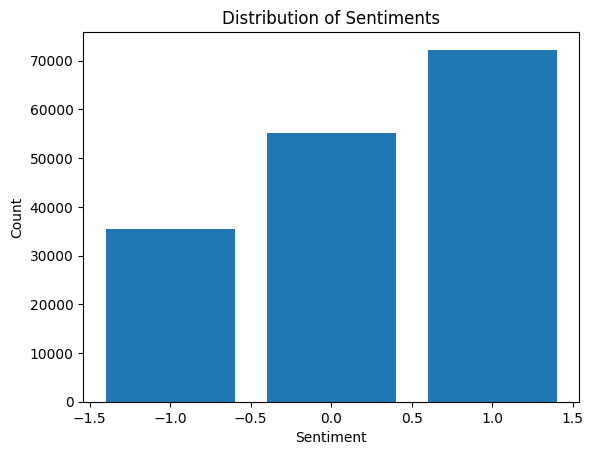

In [17]:
sentiment_counts = data['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

In [18]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = text.lower()
    text = re.findall(r'\b\w+\b', text)
    return text

data['text'] = data['text'].apply(clean_text)

In [19]:
data = data[data['text'].apply(lambda x: len(x) > 0)]

In [20]:
from sklearn.model_selection import train_test_split

X = data['text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_test_tfidf = tfidf_vectorizer.transform(X_test.apply(lambda x: ' '.join(x)))

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [23]:
y_pred = nb_classifier.predict(X_test_tfidf)

In [24]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7401282483968951
Classification Report:
               precision    recall  f1-score   support

          -1       0.90      0.42      0.57      7153
           0       0.87      0.68      0.76     10968
           1       0.66      0.95      0.78     14472

    accuracy                           0.74     32593
   macro avg       0.81      0.68      0.70     32593
weighted avg       0.79      0.74      0.73     32593



In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = rf_classifier.predict(X_test_tfidf)

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8453962507286841
Classification Report:
               precision    recall  f1-score   support

          -1       0.90      0.60      0.72      7153
           0       0.84      0.92      0.88     10968
           1       0.83      0.91      0.87     14472

    accuracy                           0.85     32593
   macro avg       0.86      0.81      0.82     32593
weighted avg       0.85      0.85      0.84     32593



In [28]:
import tensorflow as tf
from tensorflow import keras

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [30]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_len = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

In [48]:
num_classes = 3
y_train_categorical = pd.get_dummies(y_train).values
y_test_categorical = pd.get_dummies(y_test).values

In [49]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.fit(X_train_padded, y_train_categorical, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
3667/3667 [==============================] - 207s 56ms/step - loss: 0.3862 - accuracy: 0.8600 - val_loss: 0.2216 - val_accuracy: 0.9378
Epoch 2/5
3667/3667 [==============================] - 179s 49ms/step - loss: 0.1960 - accuracy: 0.9453 - val_loss: 0.2055 - val_accuracy: 0.9425
Epoch 3/5
3667/3667 [==============================] - 181s 49ms/step - loss: 0.1746 - accuracy: 0.9512 - val_loss: 0.2039 - val_accuracy: 0.9431
Epoch 4/5
3667/3667 [==============================] - 181s 49ms/step - loss: 0.1555 - accuracy: 0.9557 - val_loss: 0.2100 - val_accuracy: 0.9405
Epoch 5/5
3667/3667 [==============================] - 179s 49ms/step - loss: 0.1379 - accuracy: 0.9603 - val_loss: 0.2129 - val_accuracy: 0.9434


In [52]:
y_pred_proba = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_proba, axis=1) - 1

print("Accuracy:", np.mean(y_pred == y_test))

1019/1019 [==============================] - 6s 6ms/step
Accuracy: 0.9470745252047986


In [53]:
input_message =  "Julia's dog died and she is not okay"

cleaned_input = clean_text(input_message)
input_sequence = tokenizer.texts_to_sequences([cleaned_input])
padded_input_sequence = pad_sequences(input_sequence, maxlen=max_len, padding='post')

predicted_proba = model.predict(padded_input_sequence)
predicted_class = np.argmax(predicted_proba) - 1

1/1 [==============================] - 0s 68ms/step


In [54]:
class_to_sentiment = {
    -1: 'Negative',
     0: 'Neutral',
     1: 'Positive'
}
predicted_sentiment_label = class_to_sentiment[predicted_class]

print("Predicted Probability:", predicted_proba)
print("Predicted Sentiment Class:", predicted_class)
print("Predicted Sentiment Label:", predicted_sentiment_label)

Predicted Probability: [[0.96344084 0.00156322 0.03499592]]
Predicted Sentiment Class: -1
Predicted Sentiment Label: Negative
